In [1]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dump_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),columns=['dup_cnt'])
    feature_dump_df = feature_dump_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dump_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [2]:
def get_human_dataset():
    feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+', header=None, names=['column_index','column_name'])
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()

    X_train = pd.read_csv('./human_activity/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)

    y_train = pd.read_csv('./human_activity/train/y_train.txt', sep='\s+',header=None, names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt', sep='\s+',header=None, names=['action'])

    return X_train, X_test, y_train, y_test

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'랜덤 포레스트 정확도 : {accuracy:.4f}')

랜덤 포레스트 정확도 : 0.9253


In [4]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [100],
    'max_depth' : [6,8,10,12],
    'min_samples_leaf' : [8,12,18],
    'min_samples_split' : [8,16,20]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print(f'최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print(f'최고 예측 정확도 : {grid_cv.best_score_:.4f}')

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도 : 0.9180


In [5]:
rf_clf1 = RandomForestClassifier(n_estimators=300,max_depth=10,min_samples_leaf=8,min_samples_split=8,random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print(f'랜덤 포레스트 정확도 : {accuracy_score(y_test, pred):.4f}')

랜덤 포레스트 정확도 : 0.9165


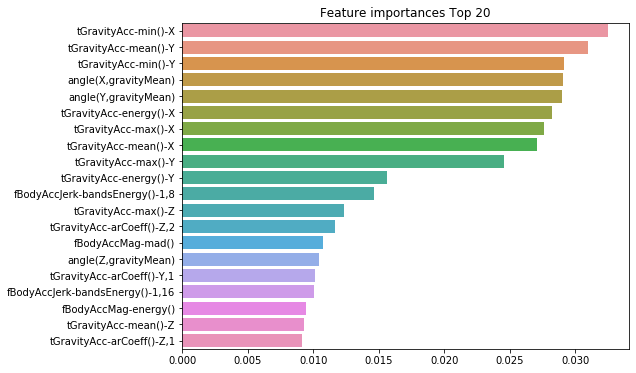

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_value = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_value, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

start_time = time.time()
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print(f'GBM 정확도: {gb_accuracy:.4f}')
print(f'GBM 수행시간: {time.time()-start_time:.1f} 초')

GBM 정확도: 0.9386
GBM 수행시간: 488.8 초


In [8]:
params = {
    'n_estimators' : [100, 500],
    'learning_rate' : [0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1,n_jobs=-1)
grid_cv.fit(X_train, y_train)
print(f'최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print(f'최고 예측 정확도: {grid_cv.best_score_:.4f}')

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:  6.4min remaining: 10.7min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 15.5min finished
최적 하이퍼 파라미터:
 {'learning_rate': 0.05, 'n_estimators': 500}
최고 예측 정확도: 0.9013
